# RU36 March 2022 Mission Analysis

JG 06/03/2022 <br>

Processing in other notebook, here just working on the analysis

In [97]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import os,sys
import glob
import datetime
import gsw
import xarray as xr
from scipy.interpolate import griddata
import scipy.interpolate as interp
from erddapy import ERDDAP
import pylab as plot
import cmocean.cm as cmo


## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/data/')
from make_dataset import inversion
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data, dist_from_lat_lon


myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%y/%m/%d\n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')


# params = {'legend.fontsize': 20,
#           'legend.handlelength': 1,
#           'legend.markerscale' : 5}

# plot.rcParams.update(params)

## Some Functions

In [98]:
# Calculate rho from conductivity, temperature, pressure, lon, lat
def gsw_rho(C, T, P, lon, lat):
        # Converts Conductivity[mS/cm], temperature[°C], and pressure[dbar] to PSU
        SP = gsw.SP_from_C(C, T, P)
        # Calculates absolute salinity (g/kg) from PSU
        SA = gsw.SA_from_SP(SP, P, lon, lat)
        # in-situ density
        rho = gsw.density.rho_t_exact(SA, T, P)
        return rho,  SP



def grid_glider_data(df, varname, delta_z=.3):
    """
    Written by aristizabal. Returns a gridded glider dataset by depth and time
    """
    df.dropna(inplace=True)
    #df.dropna() # Changed to work with ru29 2020 datatset by JG
    df.drop(df[df['depth'] < .1].index, inplace=True)  # drop rows where depth is <1
    df.drop(df[df[varname] == 0].index, inplace=True)  # drop rows where the variable equals zero
    df.sort_values(by=['time', 'depth'], inplace=True)

    # find unique times and coordinates
    timeg, ind = np.unique(df.time.values, return_index=True)
    latg = df['latitude'].values[ind]
    long = df['longitude'].values[ind]
    dg = df['depth'].values
    vg = df[varname].values
    zn = np.int(np.max(np.diff(np.hstack([ind, len(dg)]))))

    depthg = np.empty((zn, len(timeg)))
    depthg[:] = np.nan
    varg = np.empty((zn, len(timeg)))
    varg[:] = np.nan

    for i, ii in enumerate(ind):
        if i < len(timeg) - 1:
            i_f = ind[i + 1]
        else:
            i_f = len(dg)
        depthi = dg[ind[i]:i_f]
        vari = vg[ind[i]:i_f]
        depthg[0:len(dg[ind[i]:i_f]), i] = depthi
        varg[0:len(vg[ind[i]:i_f]), i] = vari

    # sort time variable
    okt = np.argsort(timeg)
    timegg = timeg[okt]
    depthgg = depthg[:, okt]
    vargg = varg[:, okt]

    # Grid variables
    depthg_gridded = np.arange(0, np.nanmax(depthgg), delta_z)
    varg_gridded = np.empty((len(depthg_gridded), len(timegg)))
    varg_gridded[:] = np.nan

    for t, tt in enumerate(timegg):
        depthu, oku = np.unique(depthgg[:, t], return_index=True)
        varu = vargg[oku, t]
        okdd = np.isfinite(depthu)
        depthf = depthu[okdd]
        varf = varu[okdd]
        ok = np.asarray(np.isfinite(varf))
        if np.sum(ok) < 3:
            varg_gridded[:, t] = np.nan
        else:
            okd = np.logical_and(depthg_gridded >= np.min(depthf[ok]), depthg_gridded < np.max(depthf[ok]))
            varg_gridded[okd, t] = np.interp(depthg_gridded[okd], depthf[ok], varf[ok])

    return timegg, long, latg, depthg_gridded, varg_gridded



def get_erddap_dataset(ds_id, server, variables=None, constraints=None, filetype=None):
    """
    Returns a netcdf dataset for a specified dataset ID (or dataframe if dataset cannot be converted to xarray)
    :param ds_id: dataset ID e.g. ng314-20200806T2040
    :param variables: optional list of variables
    :param constraints: optional list of constraints
    :param filetype: optional filetype to return, 'nc' (default) or 'dataframe'
    :return: netcdf dataset
    """
    variables = variables or None
    constraints = constraints or None
    filetype = filetype or 'nc'
    #ioos_url = 'https://data.ioos.us/gliders/erddap'


    e = ERDDAP(server,
               protocol='tabledap',
               response='nc')
    e.dataset_id = ds_id
    if constraints:
        e.constraints = constraints
    if variables:
        e.variables = variables
    if filetype == 'nc':
        try:
            ds = e.to_xarray()
            ds = ds.sortby(ds.time)
        except OSError:
            print('No dataset available for specified constraints: {}'.format(ds_id))
            ds = []
        except TypeError:
            print('Cannot convert to xarray, providing dataframe: {}'.format(ds_id))
            ds = e.to_pandas().dropna()
    elif filetype == 'dataframe':
        #ds = e.to_pandas().dropna()
        ds = e.to_pandas().dropna(how='all')
    else:
        print('Unrecognized filetype: {}. Needs to  be "nc" or "dataframe"'.format(filetype))

    return ds


# Load processed ADCP data

In [99]:
dz = 20

path = "/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP_Processed_csv/{}_meter_vertical_resolution/".format(dz)
files = np.sort(glob.glob(path+'*.csv'))
inversion_df = pd.concat(map(pd.read_csv, files))



inversion_depth         = np.arange(2.5,1030,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    inversion_df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(inversion_df.inversion_u.values)),x] = inversion_df.inversion_u.values
    v_grid[np.arange(0,len(inversion_df.inversion_v.values)),x] = inversion_df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(inversion_df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(inversion_df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = inversion_df.start_lat[0]
    inversion_start_lon[x] = inversion_df.start_lon[0]
    inversion_end_lat[x]   = inversion_df.end_lat[0]
    inversion_end_lon[x]   = inversion_df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (inversion_df.start_lat[0]+inversion_df.end_lat[0])/2
    inversion_lon[x]   = (inversion_df.start_lon[0]+inversion_df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU36 2022 RDI ADCP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds = ds.sortby(ds.time)
ds

<xarray.Dataset>
Dimensions:     (depth: 52, time: 108)
Coordinates:
  * time        (time) datetime64[ns] 2022-02-24T20:07:10.130000 ... 2022-03-...
  * depth       (depth) float64 2.5 22.5 42.5 62.5 ... 982.5 1.002e+03 1.022e+03
Data variables:
    u_grid      (depth, time) float64 -0.3124 -0.3747 -0.3337 ... nan nan nan
    v_grid      (depth, time) float64 -0.0385 0.08768 0.05681 ... nan nan nan
    latitude    (time) float64 18.15 18.15 18.15 18.15 ... 17.87 17.84 17.83
    longitude   (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.81 -64.81 -64.8
    start_lat   (time) float64 18.15 18.15 18.15 18.15 ... 17.88 17.85 17.83
    start_lon   (time) float64 -64.79 -64.8 -64.8 -64.8 ... -64.81 -64.81 -64.81
    end_lat     (time) float64 18.15 18.15 18.15 18.15 ... 17.85 17.83 17.84
    end_lon     (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.81 -64.81 -64.8
    start_time  (time) datetime64[ns] 2022-02-24T18:29:31.830000 ... 2022-03-...
    end_time    (time) datetime64[ns] 2022-02-24T20:07:10.130000 ... 2022-03-...
Attributes:
    description:  Master/combined RU36 2022 RDI ADCP least-squares inversion ...

# Load glider flight data

In [100]:
ds_id = 'ru36-20220223T1807-trajectory-raw-delayed'
#ds_id = 'ru36-20220223T1807-trajectory-raw-rt'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time','source_file', 'm_water_vx', 'm_water_vy', 'm_heading','m_final_water_vx','m_final_water_vy','m_pitch','m_roll']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times_flight = gdf.groupby('source_file').first().time.values
end_times_flight   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times_flight2 = pd.to_datetime(start_times_flight).tz_localize(None)
end_times_flight2 = pd.to_datetime(end_times_flight).tz_localize(None)

m_gps_mag_var = np.rad2deg(0.236) # 0.236 radians

gdf.time = pd.to_datetime(gdf.time)

## Correct heading and convert to degrees
heading_degrees = np.rad2deg(gdf.m_heading)-m_gps_mag_var
gdf['heading_degrees'] = heading_degrees
ind = np.where(heading_degrees.values < 0)[0]
corrected_heading = heading_degrees
corrected_heading[ind] = corrected_heading[ind]+360
gdf['corrected_heading'] = corrected_heading


gdf = gdf.sort_values(by='time')

gdf

,depth,latitude,longitude,time,source_file,m_water_vx,m_water_vy,m_heading,m_final_water_vx,m_final_water_vy,m_pitch,m_roll,heading_degrees,corrected_heading
0,0.00000,18.179557,-64.932412,2022-02-23 18:07:14.260000+00:00,ru36-2022-053-3-0-dbd(00290000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2119319,0.00000,18.179557,-64.932412,2022-02-23 18:07:14.260000+00:00,ru36-2022-053-3-0-dbd(00290000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2119320,NaN,18.179557,-64.932412,2022-02-23 18:07:15.230000+00:00,ru36-2022-053-3-0-dbd(00290000),0.0,0.0,2.45742,0.0,0.0,0.020944,-0.094248,127.277991,127.277991
1,NaN,18.179557,-64.932412,2022-02-23 18:07:15.230000+00:00,ru36-2022-053-3-0-dbd(00290000),0.0,0.0,2.45742,0.0,0.0,0.020944,-0.094248,127.277991,127.277991
2,0.00000,18.179557,-64.932412,2022-02-23 18:07:16.040000+00:00,ru36-2022-053-3-0-dbd(00290000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114852,-0.24304,18.182745,-64.847828,2022-03-17 17:21:56.340000+00:00,ru36-2022-074-1-30-dbd(00490030),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729011,NaN,17.870890,-64.801518,NaT,ru36-2022-060-0-100-dbd(00340100),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887616,NaN,NaN,NaN,NaT,ru36-2022-060-0-131-dbd(00340131),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2848330,NaN,17.870890,-64.801518,NaT,ru36-2022-060-0-100-dbd(00340100),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Make a dataframe for DAC for use in the constrained thermal wind transport calculations

In [101]:
## Proallocate memory
vx = np.empty(len(start_times_flight))
vx[:] = np.NaN
vy = np.empty(len(start_times_flight))
vy[:] = np.NaN
vx_start_lon = np.empty(len(start_times_flight))
vx_start_lon[:] = np.NaN
vx_start_lat = np.empty(len(start_times_flight))
vx_start_lat[:] = np.NaN
vx_end_lon = np.empty(len(start_times_flight))
vx_end_lon[:] = np.NaN
vx_end_lat = np.empty(len(start_times_flight))
vx_end_lat[:] = np.NaN
vx_start_tm = np.empty(len(start_times_flight),dtype=pd.Timestamp)
vx_end_tm = np.empty(len(start_times_flight),dtype=pd.Timestamp)


for x in np.arange(0,len(start_times_flight)):

    ## Subset glider df to one segment
    subsetgdf = gdf[(gdf.time >= start_times_flight[x]) & (gdf.time <= end_times_flight[x])]
    ## Pull out last non-NaN DAC
    ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
    
    ## Check if there is a DAC, if not continue onto next segment.
    if len(ind) > 0:
        vx[x]          = subsetgdf.m_water_vx.iloc[ind[-1]]
        vy[x]         = subsetgdf.m_water_vy.iloc[ind[-1]]
        
        ## Pull out last non-NaN lat/lon
        ind1         = np.argwhere(np.isnan(subsetgdf.longitude).ravel()==False).flatten()   
        vx_start_lon[x] = subsetgdf.longitude.iloc[ind1[0]]
        vx_start_lat[x] = subsetgdf.latitude.iloc[ind1[0]]
        vx_end_lon[x]   = subsetgdf.longitude.iloc[ind1[-1]]
        vx_end_lat[x]   = subsetgdf.latitude.iloc[ind1[-1]]
        ## Not using the index here because I want the segment start and end times
        vx_start_tm[x]  = subsetgdf.time.iloc[0]
        vx_end_tm[x]    = subsetgdf.time.iloc[-1]


data = {'vx': vx, 'vy': vy, 'start_lon': vx_start_lon, 'start_lat': vx_start_lat, 'end_lon': vx_end_lon,
       'end_lat': vx_end_lat, 'start_time': vx_start_tm, 'end_time': vx_end_tm}

DACdf = pd.DataFrame(data)
DACdf

,vx,vy,start_lon,start_lat,end_lon,end_lat,start_time,end_time
0,-0.026279,-0.032319,-64.932412,18.179557,-64.931677,18.177695,2022-02-23 18:07:14.260000+00:00,2022-02-23 18:22:54.850000+00:00
1,-0.048774,-0.001746,-64.931680,18.177698,-64.929235,18.175873,2022-02-23 18:55:04.260000+00:00,2022-02-23 19:32:27.080000+00:00
2,-0.048774,-0.001746,-64.929235,18.175873,-64.929235,18.175873,2022-02-23 19:35:18.260000+00:00,2022-02-23 19:35:53.750000+00:00
3,-0.048433,-0.014100,-64.929235,18.175873,-64.920892,18.171752,2022-02-23 19:35:58.790000+00:00,2022-02-23 20:40:25.320000+00:00
4,-0.048433,-0.014100,-64.920892,18.171752,-64.920892,18.171752,2022-02-23 20:43:47.260000+00:00,2022-02-23 20:44:12.730000+00:00
...,...,...,...,...,...,...,...,...
396,-0.099611,0.000121,-64.815107,18.161050,-64.815107,18.161050,2022-03-17 01:40:54.640000+00:00,2022-03-17 01:42:33.650000+00:00
397,-0.046964,-0.008903,-64.815107,18.161050,-64.829722,18.169372,2022-03-17 01:42:37.650000+00:00,2022-03-17 03:19:50.990000+00:00
398,-0.046964,-0.008903,-64.829722,18.169372,-64.829722,18.169372,2022-03-17 03:19:55+00:00,2022-03-17 03:21:48.990000+00:00
399,-0.016464,-0.036245,-64.829722,18.169372,-64.826620,18.167968,2022-03-17 03:21:52.990000+00:00,2022-03-17 05:03:21.580000+00:00


# Load glider science data

In [102]:
ds_id = 'ru36-20220223T1807-profile-sci-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'salinity', 'temperature','density','source_file', 'profile_id']
sci_gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
sci_gdf.columns = variables


## Great way to find start and end times!!
start_times = sci_gdf.groupby('source_file').first().time.values
end_times   = sci_gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

## Format time
sci_gdf.time = pd.to_datetime(sci_gdf.time.values).tz_localize(None).values

## Quick QC
sci_gdf.density.values[sci_gdf.density>1040] = np.NaN
sci_gdf.temperature.values[sci_gdf.temperature>50] = np.NaN
sci_gdf.salinity.values[sci_gdf.salinity>50] = np.NaN

sci_gdf.time = pd.to_datetime(sci_gdf.time)
sci_gdft = sci_gdf.set_index('time')
sci_gdft = sci_gdft.sort_values(by='time')

sci_gdft

,depth,latitude,longitude,salinity,temperature,density,source_file,profile_id
time,,,,,,,,
2022-02-23 18:07:57.020,0.104071,18.178870,-64.933555,35.767017,26.2562,1023.53357,ru36-2022-053-3-0-dbd(00290000),1645639888
2022-02-23 18:07:57.020,0.104071,18.178870,-64.933555,35.767017,26.2562,1023.53357,ru36-2022-053-3-0-dbd(00290000),1645639888
2022-02-23 18:07:57.060,NaN,18.178870,-64.933555,NaN,NaN,NaN,ru36-2022-053-3-0-dbd(00290000),1645639888
2022-02-23 18:07:57.060,NaN,18.178870,-64.933555,NaN,NaN,NaN,ru36-2022-053-3-0-dbd(00290000),1645639888
2022-02-23 18:07:58.020,NaN,18.178869,-64.933557,NaN,NaN,NaN,ru36-2022-053-3-0-dbd(00290000),1645639888
...,...,...,...,...,...,...,...,...
2022-03-17 17:18:52.030,2.241361,18.182739,-64.847556,NaN,NaN,NaN,ru36-2022-074-1-30-dbd(00490030),1647537378
2022-03-17 17:18:56.030,1.593261,18.182738,-64.847571,NaN,NaN,NaN,ru36-2022-074-1-30-dbd(00490030),1647537378
2022-03-17 17:19:00.040,0.275446,18.182737,-64.847585,NaN,NaN,NaN,ru36-2022-074-1-30-dbd(00490030),1647537378


## Make a map

In [103]:
# # grab bathymetry data for a map
# import cartopy.crs as ccrs

# #lat_lims = [16, 19]
# #lon_lims = [-66.5, -60.5]
# ## Zoomed window
# lat_lims = [17.5, 18.6]
# lon_lims = [-65.5, -64]


# # grab some bathymetry
# url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

# etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))

# fig = plt.figure(figsize=(15,20))
# ax = plt.subplot( projection= ccrs.Mercator())

# ## Good but too smooth
# dpth_contours = np.arange(-2000, 1, 200)
# ## Good but want more resolution at the shelf break
# #dpth_contours = np.append(np.arange(-5000, -2000, 500), np.arange(-2000, 1, 1000)) 


# #dpth_contours = np.append(np.arange(-5000, -1000, 1000), np.arange(-1000, 1, 500)) 
# #plt.plot(gdf.longitude.values, gdf.latitude.values, 'k',linewidth=6, transform=ccrs.PlateCarree(),color='black')


# plt.plot(gdf.longitude, gdf.latitude,'.', transform=ccrs.PlateCarree(),color='black')


# plt.contourf(etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours, transform=ccrs.PlateCarree(), cmap='Blues_r', zorder=0,extend='both')
# plt.colorbar(label='Depth [m]',pad=0.03, fraction=0.035)
# ax.coastlines()

# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='black',linewidth=0.5)
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 12}
# gl.ylabel_style = {'size': 12}

# #plt.savefig('/Users/joegradone/Desktop/RU29_2021_Anegada_Map.png',dpi=300,facecolor='white')

## Manually pick out points for transects (based on Google Earth KMZ)

In [104]:
################################################
#2022-02-27 15:36:47 # Start #1
#2022-03-01 03:50:37 # End #1

#2022-03-01 03:50:37 # Start #2
#2022-03-02 13:07:40 # End #2

#2022-03-02 16:23:19 # Start #3
#2022-03-03 22:10:11 # End #3

#2022-03-03 22:10:11 # Start #4
#2022-03-05 06:43:08 # End #4

#2022-03-05 06:43:08 # Start #5
#2022-03-06 15:50:51 # End #5

#2022-03-06 15:50:51 # Start #6
#2022-03-08 01:36:52 # End #6

#2022-03-08 01:36:52 # Start #7
#2022-03-09 11:18:04 # End #7

#2022-03-09 11:18:04 # Start #8
#2022-03-11 01:01:33 # End #8
################################################

start_ind1 = '2022-02-27 15:36:47'
end_ind1   = '2022-03-01 03:50:37'

start_ind2 = '2022-03-01 03:50:37'
end_ind2   = '2022-03-02 13:07:40'

start_ind3 = '2022-03-02 16:23:19'
end_ind3   = '2022-03-03 22:10:11'

start_ind4 = '2022-03-03 22:10:11'
end_ind4   = '2022-03-05 06:43:08'

start_ind5 = '2022-03-05 06:43:08'
end_ind5   = '2022-03-06 15:50:51'

start_ind6 = '2022-03-06 15:50:51'
end_ind6   = '2022-03-08 01:36:52'

start_ind7 = '2022-03-08 01:36:52'
end_ind7   = '2022-03-09 11:18:04'

start_ind8 = '2022-03-09 11:18:04'
end_ind8   = '2022-03-11 01:01:33'

transect_start_times = [start_ind1, start_ind2, start_ind3, start_ind4, start_ind5, start_ind6, start_ind7, start_ind8]
transect_end_times   = [end_ind1, end_ind2, end_ind3, end_ind4, end_ind5, end_ind6, end_ind7, end_ind8]

## Weird DAC from bad GPS hit during first leg

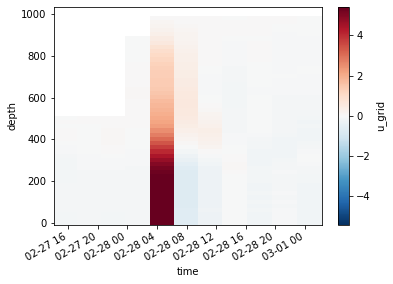

In [105]:
y=0
subset_ds_sect = ds.sel(time=slice(transect_start_times[y],transect_end_times[y]))
sci_gdf = sci_gdft[transect_start_times[y]:transect_end_times[y]]
DACdf2 = DACdf.loc[(DACdf.start_time >= transect_start_times[y]) & (DACdf.end_time >= transect_end_times[y]) ]
subset_ds_sect.u_grid.plot()

## Grid interpolation done on the RU29 data

In [106]:
lat_grid = np.arange(17.85,18.11,0.05) ## fine grid (18.11 so that 0.5 spacing includes 18.1)

## lon_grid
lon_grid = np.repeat(-64.80,len(lat_grid)) # Just make it -64.80


## vertical grid to do thermal wind on
geo_dz = 2
griddepth = np.arange(0,1001,geo_dz)

## vertical grid of inversion data, will interp onto this after calculating geostrophic velocity
inversion_depth = ds.depth.values

## Make grid
X, Y, Z = np.meshgrid(lon_grid, lat_grid, griddepth)


gridvelu = np.empty((len(inversion_depth),len(lat_grid),6))
gridvelu[:] = np.NaN
gridvelv = np.empty((len(inversion_depth),len(lat_grid),6))
gridvelv[:] = np.NaN
gridtemp = np.empty((len(griddepth),len(lat_grid),6))
gridtemp[:] = np.NaN
gridsalinity = np.empty((len(griddepth),len(lat_grid),6))
gridsalinity[:] = np.NaN
griddensity = np.empty((len(griddepth),len(lat_grid),6))
griddensity[:] = np.NaN
gridvx = np.empty((len(lat_grid),6))
gridvx[:] = np.NaN


## Go 1:7 because the 1st transect has a weird DAC on one leg and the last transect is cut short
for y in np.arange(1,7):

    ## ADCP
    subset_ds_sect = ds.sel(time=slice(transect_start_times[y],transect_end_times[y]))
    sci_gdf2 = sci_gdft[transect_start_times[y]:transect_end_times[y]]
    DACdf2 = DACdf.loc[(DACdf.start_time >= transect_start_times[y]) & (DACdf.end_time >= transect_end_times[y]) ]

    profile_IDs = np.unique(sci_gdf2.profile_id)
    profileid_start_index = np.empty(len(profile_IDs),dtype='int')
    profileid_end_index = np.empty(len(profile_IDs),dtype='int')
    
    for x in np.arange(0,len(profile_IDs)):
        profileid_start_index[x] = np.where(sci_gdf2.profile_id == profile_IDs[x])[0][0]
        profileid_end_index[x] = np.where(sci_gdf2.profile_id == profile_IDs[x])[0][-1]
    
    tgriddensity = np.empty((len(griddepth),len(profile_IDs)))
    tgriddensity[:] = np.NaN
    tgridtemp = np.empty((len(griddepth),len(profile_IDs)))
    tgridtemp[:] = np.NaN
    tgridsalinity = np.empty((len(griddepth),len(profile_IDs)))
    tgridsalinity[:] = np.NaN
    profile_lats = np.empty((len(profile_IDs)))
    profile_lats[:] = np.NaN
    profile_lons = np.empty((len(profile_IDs)))
    profile_lons[:] = np.NaN
    
    
    for x in np.arange(0,len(profile_IDs)):
        tgriddensity[:,x] = interp.griddata(sci_gdf2.depth.values[profileid_start_index[x]:profileid_end_index[x]],sci_gdf2.density.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        tgridtemp[:,x] = interp.griddata(sci_gdf2.depth.values[profileid_start_index[x]:profileid_end_index[x]],sci_gdf2.temperature.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        tgridsalinity[:,x] = interp.griddata(sci_gdf2.depth.values[profileid_start_index[x]:profileid_end_index[x]],sci_gdf2.salinity.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        profile_lats[x] = sci_gdf2.latitude.values[profileid_start_index[x]]
        profile_lons[x] = sci_gdf2.longitude.values[profileid_start_index[x]]

    ## Drop columns of all nan
    tgridtemp = tgridtemp[:,~np.isnan(tgridtemp).all(axis=0)]
    tgridsalinity = tgridsalinity[:,~np.isnan(tgridsalinity).all(axis=0)]
    tgriddensity = tgriddensity[:,~np.isnan(tgriddensity).all(axis=0)]
    
    ##### y-1 here because starting the y loop at 1 from the bad DAC on the first transect
    gridvx[:,y-1] = interp.griddata(DACdf2.start_lat.values, DACdf2.vx.values, lat_grid, method='nearest')
#     ## Taking mean DAC in lat bin instead of interp
#     for x in np.arange(0,len(lat_grid)-2):
#         ind = np.where((DACdf2.start_lat >= lat_grid[x]) & (DACdf2.start_lat <= lat_grid[x+1]))
#         gridvx[x,y-1] = np.nanmean(DACdf2.vx.values[ind[0]])
    

    for x in np.arange(0,len(griddepth)):
        gridtemp[x,:,y-1] = interp.griddata(profile_lats, tgridtemp[x,:], lat_grid, method='nearest')
        gridsalinity[x,:,y-1] = interp.griddata(profile_lats, tgridsalinity[x,:], lat_grid, method='nearest')
        griddensity[x,:,y-1] = interp.griddata(profile_lats, tgriddensity[x,:], lat_grid, method='nearest')
        
    for x in np.arange(0,len(inversion_depth)):
        ##### y-1 for all of these because starting the y loop at 1 from the bad DAC on the first transect
        gridvelu[x,:,y-1] = interp.griddata(subset_ds_sect.latitude.values, subset_ds_sect.u_grid.values[x,:], lat_grid, method='nearest')
        gridvelv[x,:,y-1] = interp.griddata(subset_ds_sect.latitude.values, subset_ds_sect.v_grid.values[x,:], lat_grid, method='nearest')
       

totgriddensity = np.nanmean(griddensity,axis=2)

meangridu = np.nanmean(gridvelu,axis=2)
meangridv = np.nanmean(gridvelv,axis=2)
stdgridu  = np.nanstd(gridvelu, axis=2)
stdgridv  = np.nanstd(gridvelv, axis=2)

/tmp/ipykernel_59597/1876402611.py:91: RuntimeWarning: Mean of empty slice
  totgriddensity = np.nanmean(griddensity,axis=2)
/tmp/ipykernel_59597/1876402611.py:93: RuntimeWarning: Mean of empty slice
  meangridu = np.nanmean(gridvelu,axis=2)
/tmp/ipykernel_59597/1876402611.py:94: RuntimeWarning: Mean of empty slice
  meangridv = np.nanmean(gridvelv,axis=2)
/home/jg1200/.conda/envs/glider_3_9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


# Geostrophic Velocity Calculation

## Calculate $\frac{\partial \rho}{\partial y}$

/tmp/ipykernel_59597/2710877636.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,totgriddensity,cmap=cmo.dense)


Text(0.5, 1.0, 'Deployment Mean Density')

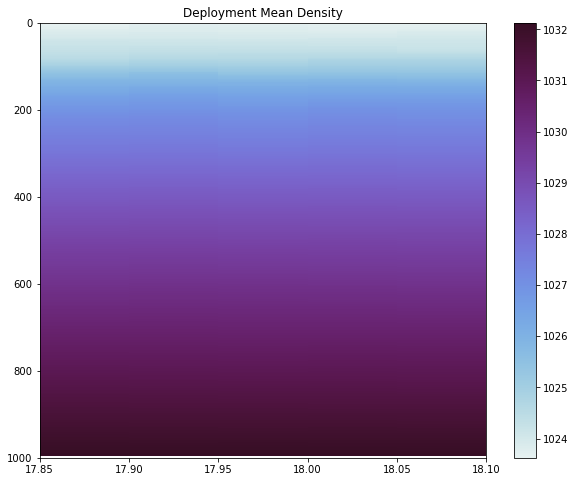

In [109]:
plt.figure(figsize=(10,8))
plt.pcolormesh(lat_grid,griddepth,totgriddensity,cmap=cmo.dense)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Deployment Mean Density')

In [110]:
distance = dist_from_lat_lon(lat_grid[0], lon_grid[0], lat_grid[1], lon_grid[0])
distance

5561.491661479939

In [111]:
d_rho_dy = np.gradient(griddensity,distance,axis=1)

tot_d_rho_dy = np.gradient(totgriddensity,distance,axis=1)

/tmp/ipykernel_59597/1447371370.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,tot_d_rho_dy)


Text(0.5, 1.0, 'Deployment Averaged')

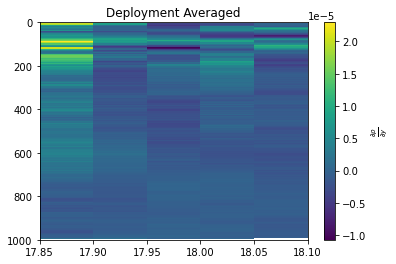

In [112]:
plt.pcolormesh(lat_grid,griddepth,tot_d_rho_dy)
plt.colorbar(label = r'$\frac{\partial \rho}{\partial y}$')
plt.gca().invert_yaxis()
plt.title('Deployment Averaged')


/tmp/ipykernel_59597/596945473.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,d_rho_dy[:,:,3])


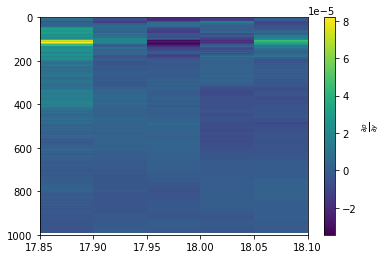

In [113]:
plt.pcolormesh(lat_grid,griddepth,d_rho_dy[:,:,3])
plt.colorbar(label = r'$\frac{\partial \rho}{\partial y}$')
plt.gca().invert_yaxis()

# get $\frac{\partial u}{\partial z}$

ok, now we have all the components of the right hand side to give us how the velocity changes with depth :

$$
\frac{g}{\rho f}\frac{\partial \rho}{\partial y}
$$

In [114]:
import seawater as sw

CF = sw.extras.f(ds.start_lat.mean())

g = sw.eos80.g(ds.start_lat.mean(), 0)

therm_wind = (1/CF)*(g/1027)*d_rho_dy
tot_therm_wind = (1/CF)*(g/1027)*tot_d_rho_dy

/tmp/ipykernel_59597/2750907907.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,tot_therm_wind,cmap='RdBu')


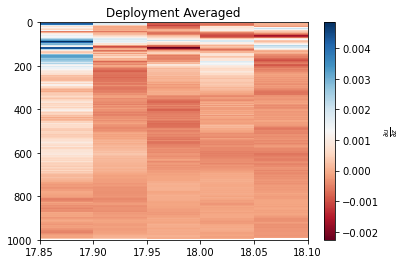

In [115]:
plt.pcolormesh(lat_grid,griddepth,tot_therm_wind,cmap='RdBu')
plt.title('Deployment Averaged')
plt.gca().invert_yaxis()
plt.colorbar(label = r'$\frac{\partial u}{\partial z}$')

# Integrate vertically to get $u$

So far we have $\frac{\partial u}{\partial z}$, or how velocity changes with depth. But what  we would really like to know is the total velocity $u$. 

We can integrate the shear to get this!

$$
u = \int \frac{du}{dz}dz
$$


or actually each little step in $v$ looks like this (just re arrainging the equation):

$$
\Delta u = \frac{\Delta u}{\Delta z} * \Delta z
$$

if you sub in the thermal wind equation it looks like this:

$$
\Delta u = \frac{-g}{\rho f}\frac{\Delta \rho}{\Delta y} * \Delta z
$$

and if we want the total $u$ we can sum up all the little $\Delta u$'s from the water column to get a profile of $u$

This actually just gives us a `relative geostrophic velocity` something we will have to reference to get the absolute velocity

In [116]:
from scipy import integrate


# replace nan with zeros for integration
therm_wind[np.where(np.isnan(therm_wind) ==True)] = 0
tot_therm_wind[np.where(np.isnan(tot_therm_wind) ==True)] = 0

# flip to integrate from bottom, then flip back
dz = np.mean(np.diff(griddepth))

rel_Vg = integrate.cumtrapz(therm_wind[::-1,:,:], dx=dz, initial=0, axis=0)[::-1,:,:]
tot_rel_Vg = integrate.cumtrapz(tot_therm_wind[::-1,:], dx=dz, initial=0, axis=0)[::-1,:]

Text(0.5, 1.0, 'Deployment Averaged Relative Geostrophic Velocity')

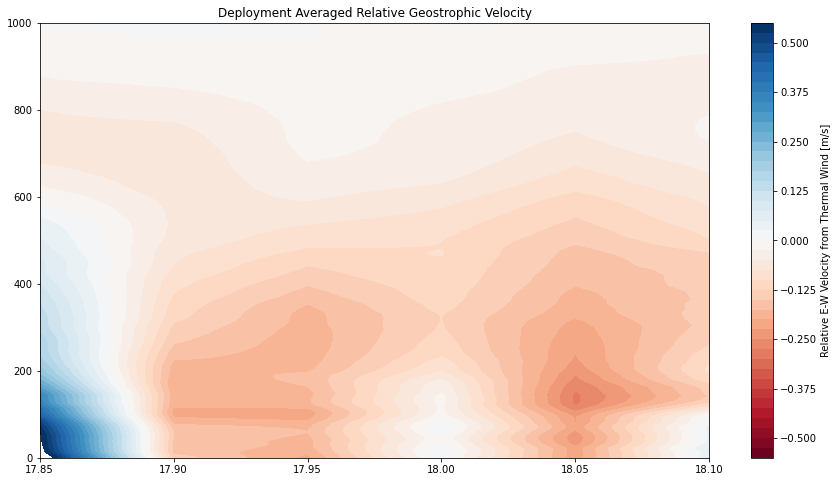

In [117]:
plt.figure(figsize=(15,8))
plt.contourf(lat_grid,griddepth,tot_rel_Vg,cmap='RdBu',levels=np.arange(-0.55,0.56,0.025))
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.title('Deployment Averaged Relative Geostrophic Velocity')

# add the reference velocity

$$
V_{abs}(x,z) = V_{rel}(x,z) + V_{ref}(x)
$$

The reference, $V_{ref}$, is calculated from the DAC ($V_{dac}$) such that:

$$
V_{ref}(x) = V_{dac} - \frac{1}{h}\int_h V_{g}(x,z)dz
$$

In [118]:
vref = gridvx - np.nanmean(rel_Vg,axis=0)

Vgeo = rel_Vg + vref

mean_Vgeo = np.nanmean(Vgeo,axis=2)


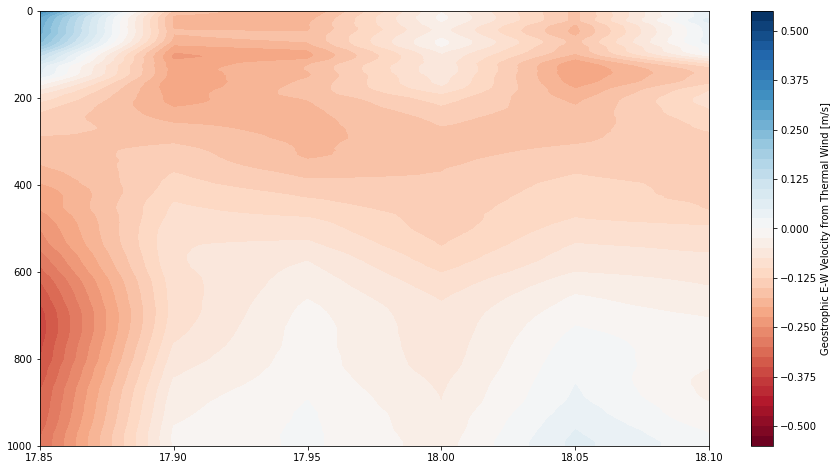

In [119]:
plt.figure(figsize=(15,8))
plt.contourf(lat_grid,griddepth,mean_Vgeo,cmap='RdBu',levels=np.arange(-0.55,0.56,0.025))
plt.colorbar(label='Geostrophic E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

## Put density on a finer grid than the ADCP data at first so now interpolate geostrophic velocity onto ADCP grid

In [120]:
Vgeo_interp = interp.griddata(griddepth,Vgeo,inversion_depth, method='linear')

gridtemp_interp = interp.griddata(griddepth,gridtemp,inversion_depth, method='linear')
gridsalinity_interp = interp.griddata(griddepth,gridsalinity,inversion_depth, method='linear')

Vgeo_interp.shape

(52, 6, 6)

In [121]:
geo_transport_gridu = np.empty(Vgeo_interp.shape[2])
geo_transport_gridu[:] = np.NaN
geo_transect_transport_profiles_u = np.empty((Vgeo_interp.shape[0],Vgeo_interp.shape[2]))
geo_transect_transport_profiles_u[:] = np.NaN
geo_transport_profiles_u = np.empty((Vgeo_interp.shape[0],Vgeo_interp.shape[1],Vgeo_interp.shape[2]))
geo_transport_profiles_u[:] = np.NaN

dz = np.mean(np.diff(inversion_depth))

for x in np.arange(0,Vgeo_interp.shape[2]):
    geo_transport_gridu[x] = (np.nansum(Vgeo_interp[:,:,x]*dz*distance))/(10**6)
    geo_transect_transport_profiles_u[:,x] = np.nanmean((Vgeo_interp[:,:,x]*dz*distance)/(10**6),axis=1)
    for y in np.arange(0,Vgeo_interp.shape[1]):
        geo_transport_profiles_u[:,y,x] = (Vgeo_interp[:,y,x]*dz*distance)/(10**6)
    
## No loop needed for the deployment averaged transport
tot_geo_transport_gridu = (np.nansum(tot_rel_Vg[:,:]*geo_dz*distance))/(10**6)
tot_geo_transport_gridu


/tmp/ipykernel_59597/1262466683.py:12: RuntimeWarning: Mean of empty slice
  geo_transect_transport_profiles_u[:,x] = np.nanmean((Vgeo_interp[:,:,x]*dz*distance)/(10**6),axis=1)


-1.8709477460025308

Text(0.5, 1.0, 'E-W Transport from Geostrophic Velocity\nRU36 March 2022')

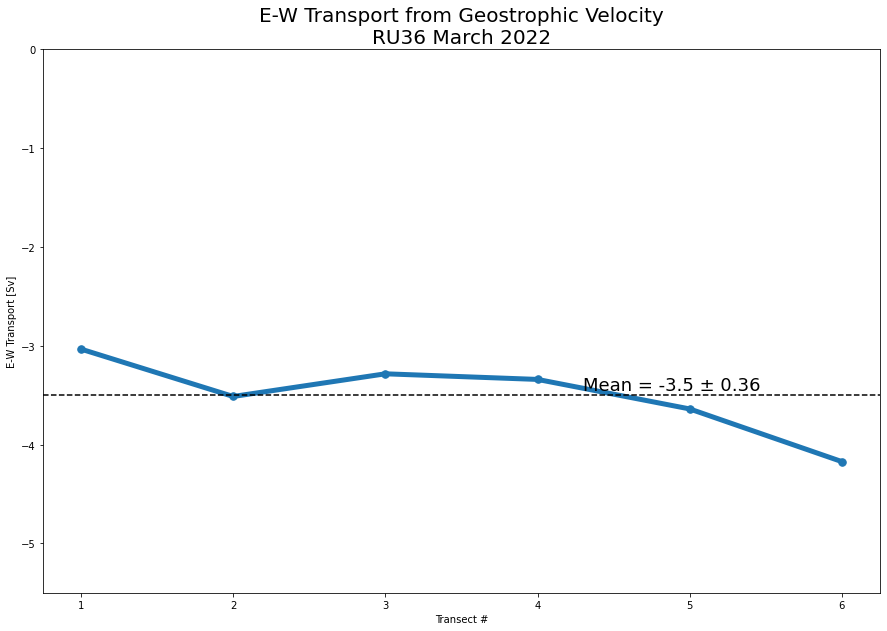

In [122]:
# plt.figure(figsize=(15,10))
# plt.plot(np.arange(1,7),geo_transport_gridu,color='tab:blue')
# plt.plot(np.arange(1,7),geo_transport_gridu,'.',color='tab:blue')
# plt.ylim(-5.5,0)
# plt.ylabel('E-W Transport [Sv]')
# plt.xlabel('Transect Number')
# plt.text(4,-4,np.round(np.nanmean(geo_transport_gridu),3),fontsize=20)

plt.figure(figsize=(15,10))
plt.plot(np.arange(1,7),geo_transport_gridu, linewidth=5,color='tab:blue')
plt.plot(np.arange(1,7),geo_transport_gridu, '.',color='tab:blue',markersize=15)
plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-5.5,0)
plt.axhline(y=np.nanmean(geo_transport_gridu), color='k', linestyle='--')
plt.text(4.3, np.nanmean(geo_transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(geo_transport_gridu),2),np.round(np.nanstd(geo_transport_gridu),2)),fontsize=18);
plt.title('E-W Transport from Geostrophic Velocity\nRU36 March 2022',fontsize=20)


In [123]:
np.nanmean(geo_transport_gridu)

-3.497637028331271

In [124]:
np.nanstd(geo_transport_gridu)

0.3561114158593965

## SAVE!

In [125]:
geo_grid_ds = xr.Dataset(
    data_vars=dict(
        u =(["depth", "lat", "transect_num"], Vgeo),
        density =(["depth", "lat", "transect_num"], griddensity),
        temp =(["depth", "lat", "transect_num"], gridtemp),
        salinity =(["depth", "lat", "transect_num"], gridsalinity)),
    coords=dict(
        depth=griddepth,
        lat=lat_grid,
        transect_num = np.arange(1,7)
    ),
    attrs=dict(description="Processed RU36 Geostrophic Velocity and T/S/Density from the 2022 Deployment gridded/interpolated onto transect latitude grid"),
)

geo_grid_ds


<xarray.Dataset>
Dimensions:       (depth: 501, lat: 6, transect_num: 6)
Coordinates:
  * depth         (depth) int64 0 2 4 6 8 10 12 ... 988 990 992 994 996 998 1000
  * lat           (lat) float64 17.85 17.9 17.95 18.0 18.05 18.1
  * transect_num  (transect_num) int64 1 2 3 4 5 6
Data variables:
    u             (depth, lat, transect_num) float64 0.7614 -0.426 ... -0.07285
    density       (depth, lat, transect_num) float64 nan nan nan ... nan nan nan
    temp          (depth, lat, transect_num) float64 nan nan nan ... nan nan nan
    salinity      (depth, lat, transect_num) float64 nan nan nan ... nan nan nan
Attributes:
    description:  Processed RU36 Geostrophic Velocity and T/S/Density from th...

In [55]:
# fname = "/home/jg1200/Data/GliderData/RU36/RU36_03_2022_Gridded_Geostrophic_Velocity.nc"
# geo_grid_ds.to_netcdf(fname)



In [126]:
# plt.figure(figsize=(15,10))
# plt.plot(np.nanmean(geo_transect_transport_profiles_u,axis=1),inversion_depth,color='black')
# plt.fill_betweenx(inversion_depth, 0,np.nanmean(geo_transect_transport_profiles_u,axis=1),color='black')
# plt.xlim(-0.01,0.01)
# plt.gca().invert_yaxis()
# plt.ylabel('Depth [m]')
# plt.xlabel('Mean E-W Geostrophic Transport per 10 Meter Depth Bin [Sv]')
# plt.title('RU36 March 2022 Anegada Passage')

## Transport calculation

In [127]:
transport_gridu = np.empty(gridvelu.shape[2])
transport_gridu[:] = np.NaN
transport_gridv = np.empty(gridvelu.shape[2])
transport_gridv[:] = np.NaN

transport_profiles_u = np.empty((gridvelu.shape[0],gridvelu.shape[1],gridvelu.shape[2]))
transport_profiles_u[:] = np.NaN
transport_profiles_v = np.empty((gridvelu.shape[0],gridvelu.shape[1],gridvelu.shape[2]))
transport_profiles_v[:] = np.NaN

transect_transport_profiles_u = np.empty((gridvelu.shape[0],gridvelu.shape[2]))
transect_transport_profiles_u[:] = np.NaN
transect_transport_profiles_v = np.empty((gridvelu.shape[0],gridvelu.shape[2]))
transect_transport_profiles_v[:] = np.NaN

for x in np.arange(0,gridvelu.shape[2]):
    transport_gridu[x] = (np.nansum(gridvelu[:,:,x]*dz*distance))/(10**6)
    transport_gridv[x] = (np.nansum(gridvelv[:,:,x]*dz*distance))/(10**6)
    transect_transport_profiles_u[:,x] = np.nanmean((gridvelu[:,:,x]*dz*distance/(10**6)),axis=1)
    transect_transport_profiles_v[:,x] = np.nanmean((gridvelv[:,:,x]*dz*distance/(10**6)),axis=1)
    
    for y in np.arange(0,gridvelu.shape[1]):
        transport_profiles_u[:,y,x] = (gridvelu[:,y,x]*dz*distance)/(10**6)
        transport_profiles_v[:,y,x] = (gridvelv[:,y,x]*dz*distance)/(10**6)
    

/tmp/ipykernel_59597/3073753130.py:19: RuntimeWarning: Mean of empty slice
  transect_transport_profiles_u[:,x] = np.nanmean((gridvelu[:,:,x]*dz*distance/(10**6)),axis=1)
/tmp/ipykernel_59597/3073753130.py:20: RuntimeWarning: Mean of empty slice
  transect_transport_profiles_v[:,x] = np.nanmean((gridvelv[:,:,x]*dz*distance/(10**6)),axis=1)


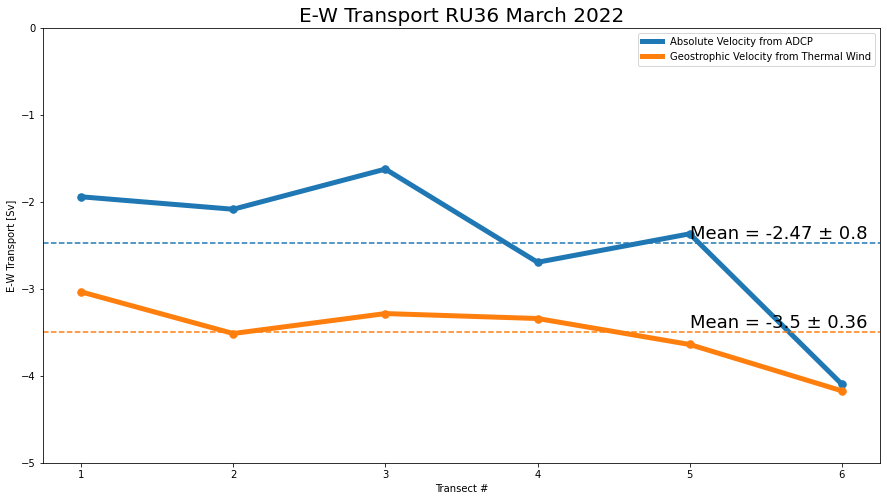

In [128]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,7),transport_gridu, linewidth=5,color='tab:blue',label='Absolute Velocity from ADCP')
plt.plot(np.arange(1,7),transport_gridu, '.',color='tab:blue',markersize=15)
plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-5,0)
plt.axhline(y=np.nanmean(transport_gridu), color='tab:blue', linestyle='--')
plt.text(5, np.nanmean(transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(transport_gridu),2),np.round(np.nanstd(transport_gridu),2)),fontsize=18);
plt.title('E-W Transport RU36 March 2022',fontsize=20)


plt.plot(np.arange(1,7),geo_transport_gridu, linewidth=5,color='tab:orange',label='Geostrophic Velocity from Thermal Wind')
plt.plot(np.arange(1,7),geo_transport_gridu, '.',color='tab:orange',markersize=15)
plt.axhline(y=np.nanmean(geo_transport_gridu), color='tab:orange', linestyle='--')
plt.text(5, np.nanmean(geo_transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(geo_transport_gridu),2),np.round(np.nanstd(geo_transport_gridu),2)),fontsize=18);

plt.legend()


## Look at how much of the transport is above/below 200 meters for comparison with Johns et al. 1999

In [129]:
depth_ind = inversion_depth < 200

test = gridvelu[depth_ind,:,:]

transport_gridu_200 = np.empty(gridvelu.shape[2])
transport_gridu_200[:] = np.NaN

for x in np.arange(0,gridvelu.shape[2]):
    transport_gridu_200[x] = (np.nansum(test[:,:,x]*dz*distance))/(10**6)


In [130]:
np.nanmax(transport_gridu_200/transport_gridu)

0.5040689434367152

## Save output for plotting later

In [131]:
# df = pd.DataFrame(np.column_stack([transport_gridu, transport_gridv]), columns=['transport_u','transport_v'])

# df.to_csv('/home/jg1200/Data/GliderData/RU36/transport.csv')

In [132]:
# plt.figure(figsize=(15,10))
# plt.plot(np.nanmean(geo_transect_transport_profiles_u,axis=1)/2,inversion_depth,color='grey',linewidth=4,label='Geostrophic Transport')
# plt.fill_betweenx(inversion_depth, 0,np.nanmean(geo_transect_transport_profiles_u,axis=1)/2,color='grey')

# plt.plot(np.nanmean(transect_transport_profiles_u,axis=1)/2,inversion_depth,color='black',linewidth=4,label='Absolute Transport')
# plt.fill_betweenx(inversion_depth, 0,np.nanmean(transect_transport_profiles_u,axis=1)/2,color='black')


# plt.xlim(-0.01,0.01)
# plt.gca().invert_yaxis()
# plt.ylabel('Depth [m]')
# plt.xlabel('Mean E-W Transport per 10 Meter Depth Bin [Sv]')
# plt.title('RU36 March 2022 Anegada Passage (6 Transects)')
# plt.legend()



## Save the absolute transport depth profile data for plotting elsewhere

In [133]:
# df = pd.DataFrame(np.column_stack([inversion_depth, np.nanmean(transect_transport_profiles_u,axis=1)]), columns=['depth','transport_u'])

# df.to_csv('/home/jg1200/Data/GliderData/RU36/transport_depth_profile.csv')




## Now look into transport per temperature range

In [134]:
mean_temp = np.nanmean(gridtemp_interp,axis=2)
mean_u_transport = np.nanmean(transport_profiles_u,axis=2)
mean_salinity = np.nanmean(gridsalinity_interp,axis=2)

/tmp/ipykernel_59597/2506725219.py:1: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(gridtemp_interp,axis=2)
/tmp/ipykernel_59597/2506725219.py:2: RuntimeWarning: Mean of empty slice
  mean_u_transport = np.nanmean(transport_profiles_u,axis=2)
/tmp/ipykernel_59597/2506725219.py:3: RuntimeWarning: Mean of empty slice
  mean_salinity = np.nanmean(gridsalinity_interp,axis=2)


In [135]:
ind1 = np.where(mean_temp<7)
range1 = np.nansum(mean_u_transport[ind1])
print('Transport <7 degrees C',np.round(np.nansum(mean_u_transport[ind1]),4),'Sv')

ind2 = np.where(mean_temp>7)
print('Transport >7 degrees C',np.round(np.nansum(mean_u_transport[ind2]),4),'Sv')

ind3 = np.where((mean_temp>7) & (mean_temp<12))
print('Transport between 7-12 degrees C',np.round(np.nansum(mean_u_transport[ind3]),4),'Sv')

ind4 = np.where((mean_temp>12) & (mean_temp<17))
print('Transport between 12-17 degrees C',np.round(np.nansum(mean_u_transport[ind4]),4),'Sv')

ind5 = np.where((mean_temp>17) & (mean_temp<24))
print('Transport between 17-24 degrees C',np.round(np.nansum(mean_u_transport[ind5]),4),'Sv')

ind6 = np.where((mean_temp>12) & (mean_temp<24))
print('Transport between 12-24 degrees C',np.round(np.nansum(mean_u_transport[ind6]),4),'Sv')

ind7 = np.where(mean_temp>24)
print('Transport >24 degrees C',np.round(np.nansum(mean_u_transport[ind7]),4),'Sv')

Transport <7 degrees C -0.078 Sv
Transport >7 degrees C -2.39 Sv
Transport between 7-12 degrees C -0.358 Sv
Transport between 12-17 degrees C -0.5114 Sv
Transport between 17-24 degrees C -0.8664 Sv
Transport between 12-24 degrees C -1.3778 Sv
Transport >24 degrees C -0.6542 Sv


In [136]:
ind1 = np.where(mean_temp<7)
range1 = np.nansum(mean_u_transport[ind1])
print('Transport <7 degrees C',range1,'Sv')

ind2 = np.where((mean_temp>7) & (mean_temp<12))
range2 = np.nansum(mean_u_transport[ind2])
print('Transport between 12-17 degrees C',range2,'Sv')

ind3 = np.where((mean_temp>12) & (mean_temp<17))
range3 = np.nansum(mean_u_transport[ind3])
print('Transport between 17-24 degrees C',range3,'Sv')

ind4 = np.where((mean_temp>17) & (mean_temp<24))
range4 = np.nansum(mean_u_transport[ind4])
print('Transport >24 degrees C',range4,'Sv')

ind5 = np.where(mean_temp>24)
range5 = np.nansum(mean_u_transport[ind5])
print('Transport >24 degrees C',range5,'Sv')

Transport <7 degrees C -0.078010384116075 Sv
Transport between 12-17 degrees C -0.3580028831592887 Sv
Transport between 17-24 degrees C -0.5114115063647419 Sv
Transport >24 degrees C -0.8664277190573249 Sv
Transport >24 degrees C -0.6541992169292263 Sv


## Save output

In [137]:
temp_df = pd.DataFrame(np.column_stack([range1, range2, range3, range4, range5]), columns=['range1','range2','range3','range4','range5'])
temp_df

temp_df.to_csv('/home/jg1200/Data/GliderData/RU36/transport_per_temperature_class_2022.csv')



In [138]:
temp_df = np.array([range1, range2, range3, range4, range5])
temp_df

array([-0.07801038, -0.35800288, -0.51141151, -0.86642772, -0.65419922])

In [140]:
min_temp = 17
max_temp = 19
min_sal  = 36.25
max_sal  = 36.75

ind18t = np.argwhere((mean_temp>=min_temp) & (mean_temp<=max_temp))
ind18s = np.argwhere((mean_salinity>=min_sal) & (mean_salinity<=max_sal))


### THE ORDER OF THIS NESTED LOOP MATTERS!
ind18 = np.array([i for i in ind18t if i in ind18s])
#ind18

In [141]:
np.nansum(mean_u_transport[ind18[:,0], ind18[:,1]])

-0.3540870850399005

In [142]:
min_temp = 17
max_temp = 19
min_sal  = 36.25
max_sal  = 36.75


ind18 = np.argwhere((mean_temp >= min_temp) & (mean_temp <= max_temp) & (mean_salinity >= min_sal) & (mean_salinity <= max_sal))

transport_u_18 = np.nansum(mean_u_transport[ind18[:,0], ind18[:,1]])

transport_u_18


-0.3540870850399005